In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib import ticker

### Load data
- `data/top-15-fraction.txt`
  - percentage of reads of gene with top 15 TPM in total mapped reads
  - rows for genes `"gene_id|gene_name"`, columns for samples
- `data/top-15-TPM.txt`: TPM of gene with top 15 TPM
  - rows for genes, columns for samples

In [2]:
top15fraction =  pd.read_csv("data/top-15-fraction.txt",sep="\t",index_col=0)
top15TPM = pd.read_csv("data/top-15-TPM.txt",sep="\t",index_col=0)

# Sort genes by their mean fractions in the library 
ordered_gene_ids = top15fraction.mean(axis=1).sort_values(ascending=True).index
top15fraction = top15fraction.loc[ordered_gene_ids,:]
top15TPM = top15TPM.loc[ordered_gene_ids,:]

### Prepare metadata for plotting
- `data/metadata.txt`: path of metadata
- Field `label`: sample type
- Field `name`: name you want to display in the figure for certain sample type

In [3]:
metadata = pd.read_csv("data/metadata.txt",sep="\t",index_col=0)
name_mapping = pd.Series(dict(zip(metadata["label"].values,metadata["name"].values)))
name_mapping = name_mapping.loc[sorted(name_mapping.index)]

### Plotting
- If want to change order of sample of different classes, simply reorder `name_mapping`
- Like this

```python
name_mapping.index
# Index(['T1', 'T2', 'T3', 'T4', 'T5', 'T6'], dtype='object')
name_mapping = name_mapping.loc[[ 'T6','T1', 'T2', 'T3', 'T4', 'T5']]
```

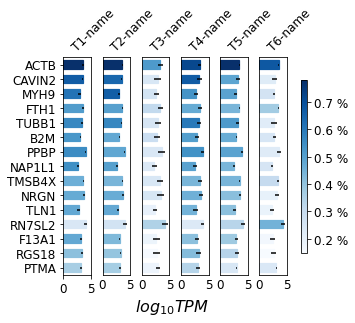

In [4]:
fig,axes = plt.subplots(1,6,figsize=(4,4))

# Get a blue color map
cmap = matplotlib.cm.get_cmap("Blues")
M = top15fraction.max().mean()
m = top15fraction.min().mean()
sm = ScalarMappable(cmap=cmap,norm=plt.Normalize(m,M))


for i,label in enumerate(name_mapping.index):
    sample_ids = metadata[metadata["label"]==label].index
    sample_ids = np.intersect1d(sample_ids,top15fraction.columns)
    
    # Width of bar
    mean = np.log10(top15TPM.loc[:,sample_ids]).mean(axis=1)
    # Width of error bar
    std = np.log10(top15TPM.loc[:,sample_ids]).std(axis=1)
    
    # Plotting
    _ = axes[i].barh(y=mean.index.map(lambda x:x.split("|")[1]),
                width=mean.values,xerr=std.values,
               edgecolor="black",lw=1.2,height=0.6)
    
    # Map percentages to colors
    colors = sm.to_rgba(top15fraction.loc[:,sample_ids].mean(axis=1).values)
    
    # Manually change color of each bar
    for j in range(len(axes[i].patches)):
        axes[i].patches[j].set_color(colors[j])
        
    _ = plt.setp(axes[i].get_xticklabels(),fontsize=12)#,weight="bold")
    _ = plt.setp(axes[i].get_yticklabels(),fontsize=12)#,weight="bold")
    axes[i].set_ylim(-0.5,14.5)
    #ax.set_xlim(0,5)
    axes[i].set_xlim(0,5)
    axes[i].set_title(name_mapping.loc[label],rotation=45,ha="left",rotation_mode="anchor")
    if i >0:
        axes[i].set_yticklabels([])
        axes[i].yaxis.set_tick_params(length=0)
        axes[i].xaxis.set_tick_params(length=0)
    plt.subplots_adjust(wspace=0.4)
    
# Set label of x axis
fig.text(0.5, 0., "$log_{10}TPM$", ha='center',fontsize=16)

# Manually add a color bar
cbaxes = fig.add_axes([0.95, 0.2, 0.02, 0.6]) 
cb = plt.colorbar(sm,cax=cbaxes)

# Fix tick location
ticks_locs = cb.ax.get_yticks().tolist()
cb.ax.yaxis.set_major_locator(ticker.FixedLocator(ticks_locs))
yticklabels = [str(np.round(loc,2))+" %" for loc in ticks_locs]
_ = cb.ax.set_yticklabels(yticklabels) 
cb.ax.tick_params(labelsize=12)

# Save figure
plt.savefig("top-15-genes.pdf",bbox_inches="tight")